# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

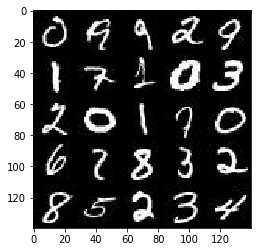

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

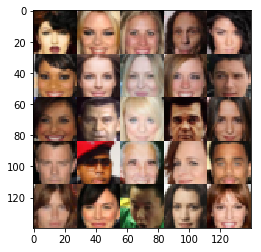

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, shape=(None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, shape=None, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [38]:
def leaky_relu(x, alpha=0.2, name='leaky_relu'):
            return tf.maximum(x, alpha * x, name=name)

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        layer1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same',
                                  kernel_initializer=tf.contrib.layers.xavier_initializer())
        layer1 = leaky_relu(layer1)
        
        layer2 = tf.layers.conv2d(layer1, 128, 5, strides=2, padding='same',
                                  kernel_initializer=tf.contrib.layers.xavier_initializer())
        layer2 = tf.layers.batch_normalization(layer2, training=True)
        layer2 = leaky_relu(layer2)
        
        layer3 = tf.layers.conv2d(layer2, 256, 5, strides=2, padding='same',
                                  kernel_initializer=tf.contrib.layers.xavier_initializer())
        layer3 = tf.layers.batch_normalization(layer3, training=True)
        layer3 = leaky_relu(layer3)
        
        # layer4 = tf.layers.conv2d(layer3, 512, 5, strides=2, padding='same',
        #                           kernel_initializer=tf.contrib.layers.xavier_initializer())
        # layer4 = tf.layers.batch_normalization(layer4, training=True)
        # layer4 = leaky_relu(layer4)
        
        layer4 = tf.nn.dropout(layer3, 0.8)
        
        flat = tf.reshape(layer3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [33]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        layer1 = tf.layers.dense(z, 7 * 7 * 512)
        layer1 = tf.reshape(layer1, (-1, 7, 7, 512))
        layer1 = leaky_relu(layer1)
        
        layer2 = tf.layers.conv2d_transpose(layer1, 256, 5, strides=2, padding='same',
                                            kernel_initializer = tf.contrib.layers.xavier_initializer())
        layer2 = tf.layers.batch_normalization(layer2, training=is_train)
        layer2 = leaky_relu(layer2)
        
        layer3 = tf.layers.conv2d_transpose(layer2, 128, 5, strides=2, padding='same',
                                            kernel_initializer = tf.contrib.layers.xavier_initializer())
        layer3 = tf.layers.batch_normalization(layer3, training=is_train)
        layer3 = leaky_relu(layer3)
        
        layer4 = tf.layers.conv2d_transpose(layer3, 64, 5, strides=1, padding='same',
                                            kernel_initializer = tf.contrib.layers.xavier_initializer())
        layer4 = tf.layers.batch_normalization(layer4, training=is_train)
        layer4 = leaky_relu(layer4)
        
        logits = tf.layers.conv2d_transpose(layer4, out_channel_dim, 5, strides=1, padding='same',
                                           kernel_initializer = tf.contrib.layers.xavier_initializer())
        out = tf.tanh(logits)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [39]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    smooth = 0.1
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)
        )
    )
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)
        )
    )
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, labels=tf.ones_like(d_model_fake)
        )
    )

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [40]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    trainables = tf.trainable_variables()
    d_vars = [var for var in trainables if var.name.startswith('discriminator')]
    g_vars = [var for var in trainables if var.name.startswith('generator')]
    
    all_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    g_update_ops = [var for var in all_update_ops if var.name.startswith('generator')]
    d_update_ops = [var for var in all_update_ops if var.name.startswith('discriminator')]

    with tf.control_dependencies(d_update_ops):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)

    with tf.control_dependencies(g_update_ops):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [41]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [42]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    input_real, input_z, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)

    losses = []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-0.5, 0.5, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, learn_rate: learning_rate})
                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2... Discriminator Loss: 0.5164... Generator Loss: 2.1195
Epoch 0/2... Discriminator Loss: 0.3735... Generator Loss: 3.7605
Epoch 0/2... Discriminator Loss: 1.0921... Generator Loss: 0.7423
Epoch 0/2... Discriminator Loss: 3.4478... Generator Loss: 0.0686
Epoch 0/2... Discriminator Loss: 1.8878... Generator Loss: 0.9685
Epoch 0/2... Discriminator Loss: 0.9028... Generator Loss: 1.3785
Epoch 0/2... Discriminator Loss: 0.6480... Generator Loss: 2.9652
Epoch 0/2... Discriminator Loss: 1.2978... Generator Loss: 1.0151
Epoch 0/2... Discriminator Loss: 1.2632... Generator Loss: 1.1188
Epoch 0/2... Discriminator Loss: 1.1841... Generator Loss: 1.1773


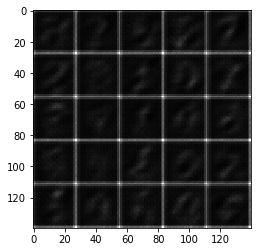

Epoch 0/2... Discriminator Loss: 1.4391... Generator Loss: 0.6559
Epoch 0/2... Discriminator Loss: 1.3493... Generator Loss: 0.9042
Epoch 0/2... Discriminator Loss: 1.2557... Generator Loss: 1.0735
Epoch 0/2... Discriminator Loss: 1.5879... Generator Loss: 1.0853
Epoch 0/2... Discriminator Loss: 1.6659... Generator Loss: 0.4159
Epoch 0/2... Discriminator Loss: 1.1477... Generator Loss: 0.7835
Epoch 0/2... Discriminator Loss: 1.4018... Generator Loss: 0.7069
Epoch 0/2... Discriminator Loss: 1.2270... Generator Loss: 1.2085
Epoch 0/2... Discriminator Loss: 1.2971... Generator Loss: 1.0480
Epoch 0/2... Discriminator Loss: 1.2195... Generator Loss: 0.9398


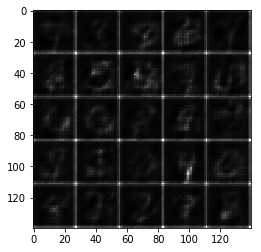

Epoch 0/2... Discriminator Loss: 1.1416... Generator Loss: 1.2123
Epoch 0/2... Discriminator Loss: 1.0630... Generator Loss: 1.2594
Epoch 0/2... Discriminator Loss: 1.2210... Generator Loss: 1.1179
Epoch 0/2... Discriminator Loss: 1.1771... Generator Loss: 1.5965
Epoch 0/2... Discriminator Loss: 1.0274... Generator Loss: 1.0956
Epoch 0/2... Discriminator Loss: 1.1222... Generator Loss: 0.8662
Epoch 0/2... Discriminator Loss: 1.0802... Generator Loss: 1.2135
Epoch 0/2... Discriminator Loss: 1.2140... Generator Loss: 0.8737
Epoch 0/2... Discriminator Loss: 1.2970... Generator Loss: 0.6319
Epoch 0/2... Discriminator Loss: 1.0512... Generator Loss: 0.9028


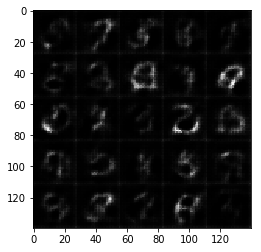

Epoch 0/2... Discriminator Loss: 1.1529... Generator Loss: 0.8238
Epoch 0/2... Discriminator Loss: 1.1155... Generator Loss: 0.8920
Epoch 0/2... Discriminator Loss: 1.3114... Generator Loss: 1.5402
Epoch 0/2... Discriminator Loss: 1.4984... Generator Loss: 0.4441
Epoch 0/2... Discriminator Loss: 1.0336... Generator Loss: 1.1142
Epoch 0/2... Discriminator Loss: 1.3711... Generator Loss: 1.4829
Epoch 0/2... Discriminator Loss: 1.8705... Generator Loss: 2.4953
Epoch 0/2... Discriminator Loss: 1.1660... Generator Loss: 1.2710
Epoch 0/2... Discriminator Loss: 1.1414... Generator Loss: 0.8941
Epoch 0/2... Discriminator Loss: 1.2590... Generator Loss: 0.6717


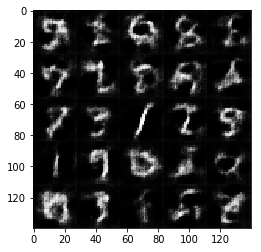

Epoch 0/2... Discriminator Loss: 1.1386... Generator Loss: 0.8728
Epoch 0/2... Discriminator Loss: 1.1891... Generator Loss: 1.0201
Epoch 0/2... Discriminator Loss: 1.1510... Generator Loss: 1.4439
Epoch 0/2... Discriminator Loss: 1.3007... Generator Loss: 0.6155
Epoch 0/2... Discriminator Loss: 1.2455... Generator Loss: 0.7574
Epoch 0/2... Discriminator Loss: 1.2368... Generator Loss: 1.3007
Epoch 0/2... Discriminator Loss: 1.2174... Generator Loss: 0.7264
Epoch 0/2... Discriminator Loss: 1.1863... Generator Loss: 0.9428
Epoch 0/2... Discriminator Loss: 1.4484... Generator Loss: 0.4666
Epoch 0/2... Discriminator Loss: 1.3213... Generator Loss: 0.6394


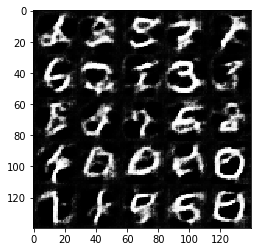

Epoch 0/2... Discriminator Loss: 1.1276... Generator Loss: 0.9005
Epoch 0/2... Discriminator Loss: 1.1317... Generator Loss: 1.2332
Epoch 0/2... Discriminator Loss: 1.2159... Generator Loss: 0.7826
Epoch 0/2... Discriminator Loss: 1.2556... Generator Loss: 1.3148
Epoch 0/2... Discriminator Loss: 1.2673... Generator Loss: 1.3978
Epoch 0/2... Discriminator Loss: 1.1695... Generator Loss: 1.0279
Epoch 0/2... Discriminator Loss: 1.1549... Generator Loss: 1.2100
Epoch 0/2... Discriminator Loss: 1.2128... Generator Loss: 0.9594
Epoch 0/2... Discriminator Loss: 1.2535... Generator Loss: 0.7690
Epoch 0/2... Discriminator Loss: 1.2448... Generator Loss: 0.9776


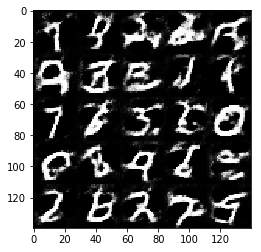

Epoch 0/2... Discriminator Loss: 1.1618... Generator Loss: 0.9069
Epoch 0/2... Discriminator Loss: 1.2834... Generator Loss: 0.6910
Epoch 0/2... Discriminator Loss: 1.2449... Generator Loss: 0.7350
Epoch 0/2... Discriminator Loss: 1.2230... Generator Loss: 0.7817
Epoch 0/2... Discriminator Loss: 1.4166... Generator Loss: 0.5187
Epoch 0/2... Discriminator Loss: 1.0909... Generator Loss: 1.0773
Epoch 0/2... Discriminator Loss: 1.2091... Generator Loss: 0.7273
Epoch 0/2... Discriminator Loss: 1.1798... Generator Loss: 0.8330
Epoch 0/2... Discriminator Loss: 1.1506... Generator Loss: 1.1003
Epoch 0/2... Discriminator Loss: 1.1745... Generator Loss: 0.9378


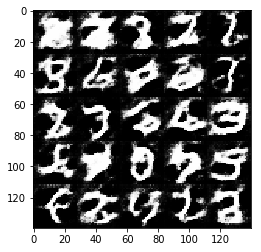

Epoch 0/2... Discriminator Loss: 1.1213... Generator Loss: 0.8962
Epoch 0/2... Discriminator Loss: 1.1863... Generator Loss: 0.8081
Epoch 0/2... Discriminator Loss: 1.1671... Generator Loss: 0.9788
Epoch 0/2... Discriminator Loss: 1.1341... Generator Loss: 1.3411
Epoch 0/2... Discriminator Loss: 1.1797... Generator Loss: 0.7123
Epoch 0/2... Discriminator Loss: 1.2755... Generator Loss: 0.7926
Epoch 0/2... Discriminator Loss: 1.1307... Generator Loss: 1.1424
Epoch 0/2... Discriminator Loss: 1.3467... Generator Loss: 0.5744
Epoch 0/2... Discriminator Loss: 1.1290... Generator Loss: 0.8637
Epoch 0/2... Discriminator Loss: 1.1150... Generator Loss: 0.8448


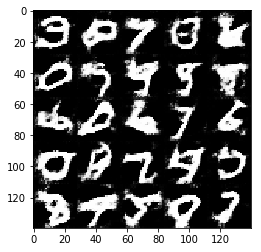

Epoch 0/2... Discriminator Loss: 1.1743... Generator Loss: 0.7896
Epoch 0/2... Discriminator Loss: 1.1150... Generator Loss: 1.2008
Epoch 0/2... Discriminator Loss: 1.1356... Generator Loss: 1.1452
Epoch 0/2... Discriminator Loss: 1.1454... Generator Loss: 0.9726
Epoch 0/2... Discriminator Loss: 1.1965... Generator Loss: 0.7239
Epoch 0/2... Discriminator Loss: 1.1895... Generator Loss: 0.8137
Epoch 0/2... Discriminator Loss: 1.1829... Generator Loss: 0.8385
Epoch 0/2... Discriminator Loss: 1.0723... Generator Loss: 0.9521
Epoch 0/2... Discriminator Loss: 1.2643... Generator Loss: 0.5830
Epoch 0/2... Discriminator Loss: 1.1919... Generator Loss: 0.7221


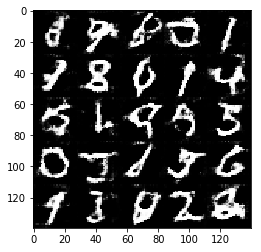

Epoch 0/2... Discriminator Loss: 1.3531... Generator Loss: 0.9443
Epoch 0/2... Discriminator Loss: 1.1924... Generator Loss: 1.2205
Epoch 0/2... Discriminator Loss: 1.2213... Generator Loss: 1.3088
Epoch 1/2... Discriminator Loss: 1.1406... Generator Loss: 0.7789
Epoch 1/2... Discriminator Loss: 1.6446... Generator Loss: 0.3914
Epoch 1/2... Discriminator Loss: 1.1831... Generator Loss: 0.7716
Epoch 1/2... Discriminator Loss: 1.0995... Generator Loss: 0.8663
Epoch 1/2... Discriminator Loss: 1.2138... Generator Loss: 1.1485
Epoch 1/2... Discriminator Loss: 1.0402... Generator Loss: 1.2114
Epoch 1/2... Discriminator Loss: 1.2182... Generator Loss: 0.6757


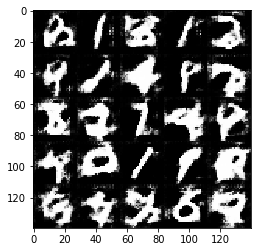

Epoch 1/2... Discriminator Loss: 1.4580... Generator Loss: 1.6961
Epoch 1/2... Discriminator Loss: 1.1532... Generator Loss: 1.0475
Epoch 1/2... Discriminator Loss: 1.1374... Generator Loss: 0.9977
Epoch 1/2... Discriminator Loss: 1.2115... Generator Loss: 1.0349
Epoch 1/2... Discriminator Loss: 1.2252... Generator Loss: 0.7782
Epoch 1/2... Discriminator Loss: 1.1964... Generator Loss: 1.3150
Epoch 1/2... Discriminator Loss: 1.1264... Generator Loss: 0.8907
Epoch 1/2... Discriminator Loss: 1.1718... Generator Loss: 0.8947
Epoch 1/2... Discriminator Loss: 1.0376... Generator Loss: 1.1632
Epoch 1/2... Discriminator Loss: 1.1941... Generator Loss: 0.8649


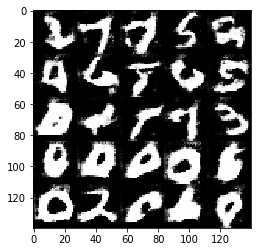

Epoch 1/2... Discriminator Loss: 1.1573... Generator Loss: 0.8524
Epoch 1/2... Discriminator Loss: 1.3906... Generator Loss: 0.5186
Epoch 1/2... Discriminator Loss: 1.1113... Generator Loss: 0.8873
Epoch 1/2... Discriminator Loss: 1.3105... Generator Loss: 0.5812
Epoch 1/2... Discriminator Loss: 1.1275... Generator Loss: 0.9274
Epoch 1/2... Discriminator Loss: 1.2038... Generator Loss: 0.7231
Epoch 1/2... Discriminator Loss: 1.2927... Generator Loss: 1.4851
Epoch 1/2... Discriminator Loss: 1.0653... Generator Loss: 1.0901
Epoch 1/2... Discriminator Loss: 1.3470... Generator Loss: 0.5434
Epoch 1/2... Discriminator Loss: 1.2107... Generator Loss: 0.6703


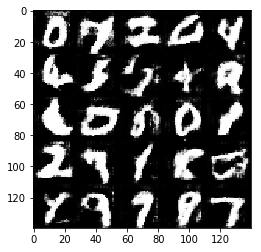

Epoch 1/2... Discriminator Loss: 1.1613... Generator Loss: 0.8712
Epoch 1/2... Discriminator Loss: 1.1846... Generator Loss: 0.8087
Epoch 1/2... Discriminator Loss: 1.3637... Generator Loss: 0.5473
Epoch 1/2... Discriminator Loss: 1.1790... Generator Loss: 0.8228
Epoch 1/2... Discriminator Loss: 1.1580... Generator Loss: 0.7933
Epoch 1/2... Discriminator Loss: 1.1873... Generator Loss: 1.0195
Epoch 1/2... Discriminator Loss: 1.3004... Generator Loss: 1.2871
Epoch 1/2... Discriminator Loss: 1.1795... Generator Loss: 0.7481
Epoch 1/2... Discriminator Loss: 0.9543... Generator Loss: 1.3478
Epoch 1/2... Discriminator Loss: 1.0466... Generator Loss: 1.0150


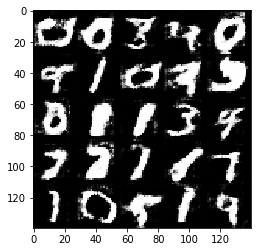

Epoch 1/2... Discriminator Loss: 1.2828... Generator Loss: 1.9668
Epoch 1/2... Discriminator Loss: 1.2070... Generator Loss: 0.9638
Epoch 1/2... Discriminator Loss: 1.1781... Generator Loss: 0.9357
Epoch 1/2... Discriminator Loss: 1.2717... Generator Loss: 0.6619
Epoch 1/2... Discriminator Loss: 1.2768... Generator Loss: 0.6272
Epoch 1/2... Discriminator Loss: 1.1028... Generator Loss: 0.9867
Epoch 1/2... Discriminator Loss: 1.2938... Generator Loss: 0.5837
Epoch 1/2... Discriminator Loss: 1.0824... Generator Loss: 1.4185
Epoch 1/2... Discriminator Loss: 1.1554... Generator Loss: 0.8823
Epoch 1/2... Discriminator Loss: 1.1469... Generator Loss: 0.9419


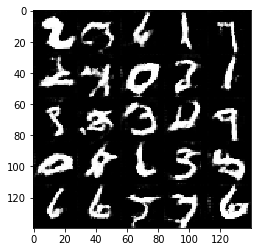

Epoch 1/2... Discriminator Loss: 1.0637... Generator Loss: 1.1040
Epoch 1/2... Discriminator Loss: 1.3302... Generator Loss: 0.6267
Epoch 1/2... Discriminator Loss: 1.2097... Generator Loss: 1.0102
Epoch 1/2... Discriminator Loss: 1.1723... Generator Loss: 0.6937
Epoch 1/2... Discriminator Loss: 1.4076... Generator Loss: 1.9878
Epoch 1/2... Discriminator Loss: 1.1485... Generator Loss: 0.8804
Epoch 1/2... Discriminator Loss: 1.1693... Generator Loss: 0.7433
Epoch 1/2... Discriminator Loss: 1.0449... Generator Loss: 1.1914
Epoch 1/2... Discriminator Loss: 1.5440... Generator Loss: 1.8510
Epoch 1/2... Discriminator Loss: 1.2663... Generator Loss: 0.7000


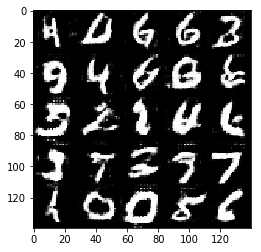

Epoch 1/2... Discriminator Loss: 1.3730... Generator Loss: 0.5688
Epoch 1/2... Discriminator Loss: 1.2042... Generator Loss: 0.7600
Epoch 1/2... Discriminator Loss: 1.0635... Generator Loss: 1.0882
Epoch 1/2... Discriminator Loss: 1.1402... Generator Loss: 1.1001
Epoch 1/2... Discriminator Loss: 1.2130... Generator Loss: 0.6355
Epoch 1/2... Discriminator Loss: 1.2143... Generator Loss: 0.7720
Epoch 1/2... Discriminator Loss: 1.1690... Generator Loss: 1.3281
Epoch 1/2... Discriminator Loss: 1.0919... Generator Loss: 0.8242
Epoch 1/2... Discriminator Loss: 1.6507... Generator Loss: 1.4174
Epoch 1/2... Discriminator Loss: 1.1769... Generator Loss: 0.9610


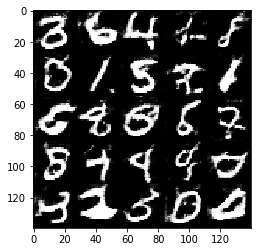

Epoch 1/2... Discriminator Loss: 1.0444... Generator Loss: 0.9933
Epoch 1/2... Discriminator Loss: 1.1741... Generator Loss: 0.7784
Epoch 1/2... Discriminator Loss: 1.0931... Generator Loss: 1.0326
Epoch 1/2... Discriminator Loss: 1.1315... Generator Loss: 1.2526
Epoch 1/2... Discriminator Loss: 1.1765... Generator Loss: 0.8036
Epoch 1/2... Discriminator Loss: 1.1103... Generator Loss: 1.0325
Epoch 1/2... Discriminator Loss: 1.1264... Generator Loss: 0.9234
Epoch 1/2... Discriminator Loss: 1.0506... Generator Loss: 0.9793
Epoch 1/2... Discriminator Loss: 1.3657... Generator Loss: 0.6633
Epoch 1/2... Discriminator Loss: 1.0427... Generator Loss: 1.1123


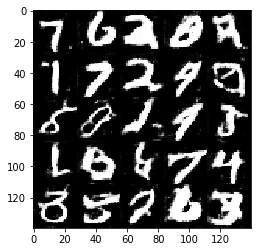

Epoch 1/2... Discriminator Loss: 1.6285... Generator Loss: 0.3924
Epoch 1/2... Discriminator Loss: 0.9814... Generator Loss: 0.9927
Epoch 1/2... Discriminator Loss: 1.3798... Generator Loss: 0.5412
Epoch 1/2... Discriminator Loss: 1.3112... Generator Loss: 0.7048
Epoch 1/2... Discriminator Loss: 0.9821... Generator Loss: 1.0963
Epoch 1/2... Discriminator Loss: 1.0570... Generator Loss: 0.9923
Epoch 1/2... Discriminator Loss: 1.0157... Generator Loss: 1.0862
Epoch 1/2... Discriminator Loss: 1.1151... Generator Loss: 0.8307
Epoch 1/2... Discriminator Loss: 1.1737... Generator Loss: 0.8015
Epoch 1/2... Discriminator Loss: 1.3240... Generator Loss: 1.0534


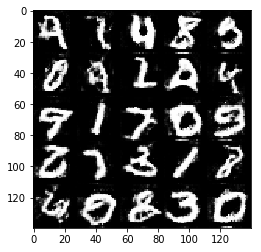

Epoch 1/2... Discriminator Loss: 1.3694... Generator Loss: 1.0340
Epoch 1/2... Discriminator Loss: 1.1501... Generator Loss: 0.8206
Epoch 1/2... Discriminator Loss: 1.3343... Generator Loss: 0.5745
Epoch 1/2... Discriminator Loss: 1.1808... Generator Loss: 1.0670
Epoch 1/2... Discriminator Loss: 1.1339... Generator Loss: 0.8535
Epoch 1/2... Discriminator Loss: 1.0535... Generator Loss: 0.9581
Epoch 1/2... Discriminator Loss: 1.1667... Generator Loss: 0.9015


In [43]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/1... Discriminator Loss: 1.3904... Generator Loss: 1.2991
Epoch 0/1... Discriminator Loss: 1.3571... Generator Loss: 0.7955
Epoch 0/1... Discriminator Loss: 1.0981... Generator Loss: 2.0338
Epoch 0/1... Discriminator Loss: 1.2093... Generator Loss: 1.1240
Epoch 0/1... Discriminator Loss: 1.3251... Generator Loss: 2.3634
Epoch 0/1... Discriminator Loss: 1.1443... Generator Loss: 1.1145
Epoch 0/1... Discriminator Loss: 1.1073... Generator Loss: 1.0252
Epoch 0/1... Discriminator Loss: 1.2505... Generator Loss: 0.8857
Epoch 0/1... Discriminator Loss: 1.3025... Generator Loss: 0.7395
Epoch 0/1... Discriminator Loss: 1.1275... Generator Loss: 2.3795


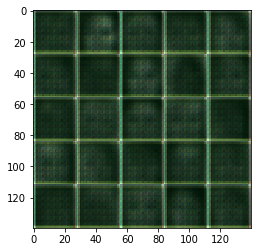

Epoch 0/1... Discriminator Loss: 1.5462... Generator Loss: 0.5518
Epoch 0/1... Discriminator Loss: 1.2637... Generator Loss: 0.9738
Epoch 0/1... Discriminator Loss: 1.2595... Generator Loss: 0.8050
Epoch 0/1... Discriminator Loss: 1.6310... Generator Loss: 0.4466
Epoch 0/1... Discriminator Loss: 1.6156... Generator Loss: 0.4529
Epoch 0/1... Discriminator Loss: 1.0539... Generator Loss: 1.9801
Epoch 0/1... Discriminator Loss: 0.9183... Generator Loss: 2.5534
Epoch 0/1... Discriminator Loss: 1.2529... Generator Loss: 0.6630
Epoch 0/1... Discriminator Loss: 1.3862... Generator Loss: 0.5516
Epoch 0/1... Discriminator Loss: 1.1443... Generator Loss: 0.8838


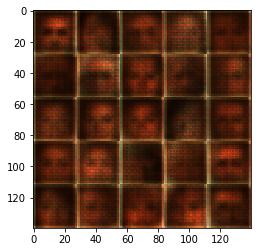

Epoch 0/1... Discriminator Loss: 1.2207... Generator Loss: 0.8074
Epoch 0/1... Discriminator Loss: 0.6901... Generator Loss: 4.6420
Epoch 0/1... Discriminator Loss: 0.9115... Generator Loss: 2.0857
Epoch 0/1... Discriminator Loss: 1.5369... Generator Loss: 0.4606
Epoch 0/1... Discriminator Loss: 1.0115... Generator Loss: 3.1124
Epoch 0/1... Discriminator Loss: 0.7099... Generator Loss: 2.3918
Epoch 0/1... Discriminator Loss: 1.1062... Generator Loss: 1.8274
Epoch 0/1... Discriminator Loss: 0.6307... Generator Loss: 2.4060
Epoch 0/1... Discriminator Loss: 1.3453... Generator Loss: 1.3516
Epoch 0/1... Discriminator Loss: 0.9549... Generator Loss: 1.3101


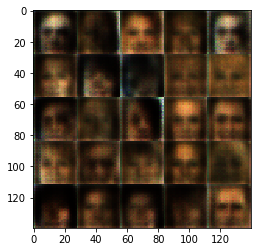

Epoch 0/1... Discriminator Loss: 0.6426... Generator Loss: 2.3790
Epoch 0/1... Discriminator Loss: 2.1018... Generator Loss: 1.7095
Epoch 0/1... Discriminator Loss: 1.4852... Generator Loss: 2.4885
Epoch 0/1... Discriminator Loss: 1.5734... Generator Loss: 1.6029
Epoch 0/1... Discriminator Loss: 1.6072... Generator Loss: 0.4154
Epoch 0/1... Discriminator Loss: 1.0900... Generator Loss: 1.0588
Epoch 0/1... Discriminator Loss: 1.1059... Generator Loss: 2.5572
Epoch 0/1... Discriminator Loss: 1.3969... Generator Loss: 0.7960
Epoch 0/1... Discriminator Loss: 1.5419... Generator Loss: 1.2927
Epoch 0/1... Discriminator Loss: 1.2505... Generator Loss: 0.6864


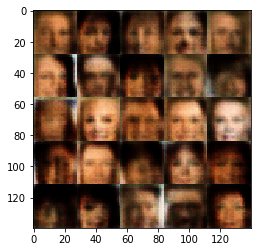

Epoch 0/1... Discriminator Loss: 1.4045... Generator Loss: 1.0623
Epoch 0/1... Discriminator Loss: 0.7544... Generator Loss: 1.6166
Epoch 0/1... Discriminator Loss: 1.2438... Generator Loss: 0.7014
Epoch 0/1... Discriminator Loss: 1.0056... Generator Loss: 0.9540
Epoch 0/1... Discriminator Loss: 1.1317... Generator Loss: 1.3286
Epoch 0/1... Discriminator Loss: 1.5929... Generator Loss: 1.5723
Epoch 0/1... Discriminator Loss: 1.4185... Generator Loss: 0.6458
Epoch 0/1... Discriminator Loss: 1.0906... Generator Loss: 1.0276
Epoch 0/1... Discriminator Loss: 1.2225... Generator Loss: 0.9882
Epoch 0/1... Discriminator Loss: 0.9883... Generator Loss: 1.6153


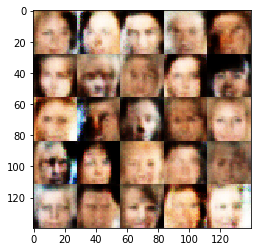

Epoch 0/1... Discriminator Loss: 1.5809... Generator Loss: 0.8558
Epoch 0/1... Discriminator Loss: 1.2737... Generator Loss: 0.7709
Epoch 0/1... Discriminator Loss: 1.3664... Generator Loss: 0.7768
Epoch 0/1... Discriminator Loss: 0.8743... Generator Loss: 1.6975
Epoch 0/1... Discriminator Loss: 0.8631... Generator Loss: 1.5683
Epoch 0/1... Discriminator Loss: 1.0282... Generator Loss: 0.9929
Epoch 0/1... Discriminator Loss: 1.1092... Generator Loss: 0.7591
Epoch 0/1... Discriminator Loss: 1.6999... Generator Loss: 0.7015
Epoch 0/1... Discriminator Loss: 1.2786... Generator Loss: 0.9426
Epoch 0/1... Discriminator Loss: 0.8307... Generator Loss: 1.5001


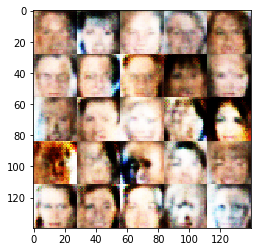

Epoch 0/1... Discriminator Loss: 1.3185... Generator Loss: 0.9813
Epoch 0/1... Discriminator Loss: 1.2571... Generator Loss: 0.8957
Epoch 0/1... Discriminator Loss: 1.2423... Generator Loss: 0.6931
Epoch 0/1... Discriminator Loss: 1.3384... Generator Loss: 1.0033
Epoch 0/1... Discriminator Loss: 1.2268... Generator Loss: 0.8538
Epoch 0/1... Discriminator Loss: 1.0882... Generator Loss: 1.5680
Epoch 0/1... Discriminator Loss: 1.2418... Generator Loss: 0.7489
Epoch 0/1... Discriminator Loss: 0.8806... Generator Loss: 1.1412
Epoch 0/1... Discriminator Loss: 1.4541... Generator Loss: 1.4623
Epoch 0/1... Discriminator Loss: 1.2833... Generator Loss: 0.7223


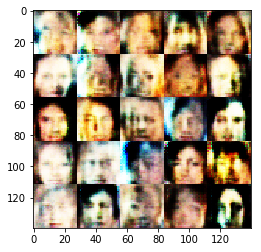

Epoch 0/1... Discriminator Loss: 0.8002... Generator Loss: 1.3720
Epoch 0/1... Discriminator Loss: 1.0490... Generator Loss: 1.2977
Epoch 0/1... Discriminator Loss: 1.7255... Generator Loss: 0.5884
Epoch 0/1... Discriminator Loss: 1.3764... Generator Loss: 0.8121
Epoch 0/1... Discriminator Loss: 1.4646... Generator Loss: 0.7858
Epoch 0/1... Discriminator Loss: 1.7382... Generator Loss: 0.3642
Epoch 0/1... Discriminator Loss: 1.0336... Generator Loss: 0.8776
Epoch 0/1... Discriminator Loss: 0.8213... Generator Loss: 1.2990
Epoch 0/1... Discriminator Loss: 1.5870... Generator Loss: 0.7187
Epoch 0/1... Discriminator Loss: 1.2819... Generator Loss: 0.9258


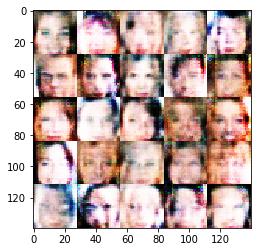

Epoch 0/1... Discriminator Loss: 1.3491... Generator Loss: 0.8607
Epoch 0/1... Discriminator Loss: 1.4549... Generator Loss: 0.8109
Epoch 0/1... Discriminator Loss: 1.4713... Generator Loss: 0.7641
Epoch 0/1... Discriminator Loss: 1.5483... Generator Loss: 0.6383
Epoch 0/1... Discriminator Loss: 1.4681... Generator Loss: 0.7419
Epoch 0/1... Discriminator Loss: 1.1916... Generator Loss: 1.0746
Epoch 0/1... Discriminator Loss: 1.4258... Generator Loss: 1.0145
Epoch 0/1... Discriminator Loss: 0.7345... Generator Loss: 1.3210
Epoch 0/1... Discriminator Loss: 2.0150... Generator Loss: 2.1954
Epoch 0/1... Discriminator Loss: 1.4149... Generator Loss: 1.3246


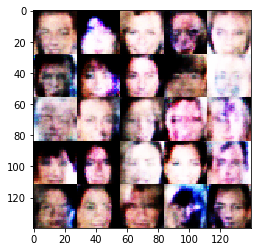

Epoch 0/1... Discriminator Loss: 1.3631... Generator Loss: 0.6576
Epoch 0/1... Discriminator Loss: 1.2950... Generator Loss: 0.8166
Epoch 0/1... Discriminator Loss: 1.1936... Generator Loss: 0.9609
Epoch 0/1... Discriminator Loss: 1.1813... Generator Loss: 0.7408
Epoch 0/1... Discriminator Loss: 1.4064... Generator Loss: 0.8780
Epoch 0/1... Discriminator Loss: 1.4478... Generator Loss: 0.7990
Epoch 0/1... Discriminator Loss: 1.3697... Generator Loss: 0.8176
Epoch 0/1... Discriminator Loss: 1.1848... Generator Loss: 1.1272
Epoch 0/1... Discriminator Loss: 1.3463... Generator Loss: 0.8921
Epoch 0/1... Discriminator Loss: 1.4535... Generator Loss: 0.7474


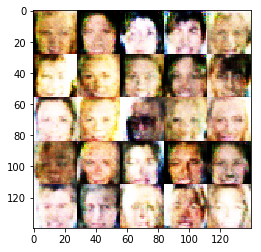

Epoch 0/1... Discriminator Loss: 1.3114... Generator Loss: 0.9189
Epoch 0/1... Discriminator Loss: 1.3793... Generator Loss: 0.7884
Epoch 0/1... Discriminator Loss: 1.4033... Generator Loss: 0.7627
Epoch 0/1... Discriminator Loss: 1.3469... Generator Loss: 0.8959
Epoch 0/1... Discriminator Loss: 1.2761... Generator Loss: 1.0584
Epoch 0/1... Discriminator Loss: 1.2689... Generator Loss: 0.7500
Epoch 0/1... Discriminator Loss: 1.2233... Generator Loss: 1.6065
Epoch 0/1... Discriminator Loss: 1.3544... Generator Loss: 0.8273
Epoch 0/1... Discriminator Loss: 1.2792... Generator Loss: 0.9355
Epoch 0/1... Discriminator Loss: 1.2388... Generator Loss: 0.8716


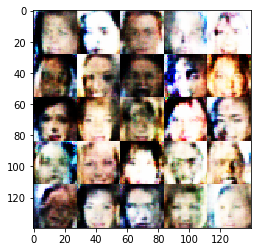

Epoch 0/1... Discriminator Loss: 1.0975... Generator Loss: 1.0096
Epoch 0/1... Discriminator Loss: 0.8753... Generator Loss: 3.3453
Epoch 0/1... Discriminator Loss: 1.4261... Generator Loss: 0.7158
Epoch 0/1... Discriminator Loss: 1.4482... Generator Loss: 1.3446
Epoch 0/1... Discriminator Loss: 0.9673... Generator Loss: 1.5378
Epoch 0/1... Discriminator Loss: 1.3645... Generator Loss: 1.4380
Epoch 0/1... Discriminator Loss: 1.2587... Generator Loss: 0.9707
Epoch 0/1... Discriminator Loss: 1.3408... Generator Loss: 1.2527
Epoch 0/1... Discriminator Loss: 1.2194... Generator Loss: 0.8576
Epoch 0/1... Discriminator Loss: 1.2757... Generator Loss: 1.0452


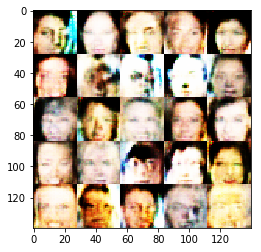

Epoch 0/1... Discriminator Loss: 1.1849... Generator Loss: 1.2221
Epoch 0/1... Discriminator Loss: 1.1213... Generator Loss: 1.1233
Epoch 0/1... Discriminator Loss: 1.2531... Generator Loss: 0.7832
Epoch 0/1... Discriminator Loss: 1.1661... Generator Loss: 0.8717
Epoch 0/1... Discriminator Loss: 1.4452... Generator Loss: 1.6195
Epoch 0/1... Discriminator Loss: 0.9823... Generator Loss: 0.8204
Epoch 0/1... Discriminator Loss: 1.3149... Generator Loss: 2.1316
Epoch 0/1... Discriminator Loss: 1.5053... Generator Loss: 0.7459
Epoch 0/1... Discriminator Loss: 1.3730... Generator Loss: 0.6742
Epoch 0/1... Discriminator Loss: 1.2345... Generator Loss: 0.6112


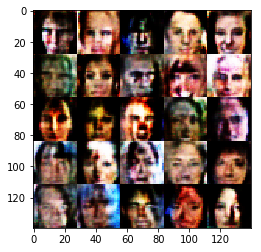

Epoch 0/1... Discriminator Loss: 0.8296... Generator Loss: 1.9116
Epoch 0/1... Discriminator Loss: 1.0922... Generator Loss: 1.7653
Epoch 0/1... Discriminator Loss: 1.3481... Generator Loss: 0.7959
Epoch 0/1... Discriminator Loss: 1.4191... Generator Loss: 0.7081
Epoch 0/1... Discriminator Loss: 1.4521... Generator Loss: 0.7027
Epoch 0/1... Discriminator Loss: 1.4628... Generator Loss: 0.7093
Epoch 0/1... Discriminator Loss: 1.5069... Generator Loss: 0.8486
Epoch 0/1... Discriminator Loss: 1.3986... Generator Loss: 0.8159
Epoch 0/1... Discriminator Loss: 1.3752... Generator Loss: 0.7336
Epoch 0/1... Discriminator Loss: 1.3783... Generator Loss: 0.8652


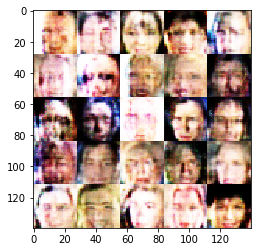

Epoch 0/1... Discriminator Loss: 1.4061... Generator Loss: 0.9469
Epoch 0/1... Discriminator Loss: 1.3794... Generator Loss: 0.8774
Epoch 0/1... Discriminator Loss: 1.3402... Generator Loss: 0.8886
Epoch 0/1... Discriminator Loss: 1.2495... Generator Loss: 0.8105
Epoch 0/1... Discriminator Loss: 1.2973... Generator Loss: 1.0000
Epoch 0/1... Discriminator Loss: 1.4152... Generator Loss: 0.7878
Epoch 0/1... Discriminator Loss: 1.3951... Generator Loss: 0.8611
Epoch 0/1... Discriminator Loss: 1.2463... Generator Loss: 0.9339
Epoch 0/1... Discriminator Loss: 1.2204... Generator Loss: 0.6863
Epoch 0/1... Discriminator Loss: 2.6159... Generator Loss: 2.2949


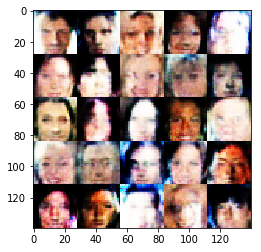

Epoch 0/1... Discriminator Loss: 1.2957... Generator Loss: 0.9230
Epoch 0/1... Discriminator Loss: 1.3932... Generator Loss: 0.8113
Epoch 0/1... Discriminator Loss: 1.2828... Generator Loss: 0.8778
Epoch 0/1... Discriminator Loss: 1.5075... Generator Loss: 0.5116
Epoch 0/1... Discriminator Loss: 1.5007... Generator Loss: 0.5076
Epoch 0/1... Discriminator Loss: 1.0530... Generator Loss: 1.1167
Epoch 0/1... Discriminator Loss: 1.6020... Generator Loss: 1.0334
Epoch 0/1... Discriminator Loss: 1.2146... Generator Loss: 0.8940


In [44]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.